In [ ]:
import numpy as np
import pandas as pd #processamento de dados, para abrir o dataset (arquivo .csv)
import itertools

from google.colab import drive #para conectar o google drive ao notebook e trazer os datasets para cá
drive.mount('/content/drive') #diretório onde o drive vai ser instaurado

#from google.colab import files #função import para justamente fazer o upload dos arquivos do drive
#uploaded = files.upload()

import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/Datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# image utils
import PIL
from PIL import Image

# import plotting
import matplotlib.pyplot as plt #biblioteca mais comum para plotar as imagens
import seaborn as sns
import scipy.stats as ss

# import machine learning
from sklearn.model_selection import StratifiedKFold #função da biblioteca sklearn para dividir os sets
from imblearn.over_sampling import RandomOverSampler, SMOTE #funções para over sampling (aumentar quantidade de ex da classe minoritária (lesão))
import xgboost as xgb #um dos modelos de ML
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score #funções que irão avaliar os modelos por meio de scores

Mounted at /content/drive
/content/drive/My Drive/Datasets/InjuryRecord.csv
/content/drive/My Drive/Datasets/PlayList.csv
/content/drive/My Drive/Datasets/PlayerTrackData.csv
/content/drive/My Drive/Datasets/Features001.csv
/content/drive/My Drive/Datasets/adult/adult.test
/content/drive/My Drive/Datasets/adult/Index
/content/drive/My Drive/Datasets/adult/adult.names
/content/drive/My Drive/Datasets/adult/adult.data
/content/drive/My Drive/Datasets/adult/old.adult.names


In [ ]:
from google.colab import drive
drive.mount('/content/drive') #instanciando o google drive novamente só pra ter certeza que vai dar certo

play_df = pd.read_csv('/content/drive/My Drive/Datasets/PlayList.csv')
#player_df = pd.read_csv('/content/drive/My Drive/Datasets/PlayerTrackData.csv')
#este último dataset foi comentado pois ele pesa 3.7 GB e estoura a memória RAM gratuita do Colab
injury_df = pd.read_csv('/content/drive/My Drive/Datasets/InjuryRecord.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Criar um DataFrame com informações a nível de jogo.
game_df = play_df[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

In [ ]:
def clean_weather(row):
    cloudy = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']

    clear = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']

    rainy = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']

    snow = ['Heavy lake effect snow']

    indoor = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']

    if row.Weather in cloudy:
        return 'Cloudy'

    if row.Weather in indoor:
        return 'Indoor'

    if row.Weather in clear:
        return 'Clear'

    if row.Weather in rainy:
        return 'Rain'

    if row.Weather in snow:
        return 'Snow'

    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan

    return row.Weather

def clean_stadiumtype(row):
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

def clean_play_df(play_df):
    play_df_cleaned = play_df.copy()

    # clean StadiumType
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 'Retractable Roof')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace('Open', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned.apply(lambda row: clean_stadiumtype(row), axis=1)

    # clean Weather
    play_df_cleaned['Weather'] = play_df_cleaned.apply(lambda row: clean_weather(row), axis=1)

    return play_df_cleaned

In [8]:
play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])


<ipython-input-5-a7d17a9c9ee9>:56: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
<ipython-input-5-a7d17a9c9ee9>:57: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
<ipython-input-5-a7d17a9c9ee9>:58: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
<ipython-input-5-a7d17a9c9ee9>:59: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cle

In [9]:
# joined cleaned games dataset and injury dataset
play_injury_df = injury_df.dropna(subset=['PlayKey']).set_index('PlayKey').join(play_df_cleaned.set_index('PlayKey'), how = 'outer', lsuffix='_left', rsuffix='_right')

# fill null values for the injury columns with zeros
play_injury_df['DM_M1'] = play_injury_df['DM_M1'].fillna(0).astype(int)
play_injury_df['DM_M7'] = play_injury_df['DM_M7'].fillna(0).astype(int)
play_injury_df['DM_M28'] = play_injury_df['DM_M28'].fillna(0).astype(int)
play_injury_df['DM_M42'] = play_injury_df['DM_M42'].fillna(0).astype(int)

# introduce a column with a flag indicating an injury
play_injury_df.DM_M1 = play_injury_df.DM_M1 - play_injury_df.DM_M7
play_injury_df.DM_M7 = play_injury_df.DM_M7 - play_injury_df.DM_M28
play_injury_df.DM_M28 = play_injury_df.DM_M28 - play_injury_df.DM_M42

play_injury_df['Injury'] = play_injury_df['DM_M1'] + play_injury_df['DM_M7'] + play_injury_df['DM_M28']+ play_injury_df['DM_M42']

# drop duplicated surface column
play_injury_df = play_injury_df.drop(columns=['Surface'])

# create dummy variables
play_injury_df_dummies = pd.get_dummies(play_injury_df, columns = ['PlayType', 'PositionGroup'], dummy_na = True, drop_first = True)

In [10]:
def visualize_play(play_df_cleaned):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1,1,figsize=(15,5))

    plt.bar(play_df_cleaned.PlayType.value_counts().keys().values, play_df_cleaned.PlayType.value_counts().values)
    plt.xticks(range(len(play_df_cleaned.PlayType.value_counts().keys().values)), play_df_cleaned.PlayType.value_counts().keys().values, rotation=20)
    add_value_labels(ax, spacing=5)
    plt.title('Play-Level Exploration: PlayType', fontsize=16)

    plt.show()

    #mesma situação dos slides anteriores, dessa vez a plotagem é para os dados de cada jogada

In [11]:
play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])


<ipython-input-5-a7d17a9c9ee9>:56: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
<ipython-input-5-a7d17a9c9ee9>:57: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
<ipython-input-5-a7d17a9c9ee9>:58: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
<ipython-input-5-a7d17a9c9ee9>:59: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cle

In [12]:
# Juntou o conjunto de dados de jogos limpo com o conjunto de dados de lesões.
game_injury_df = injury_df.set_index('GameID').join(game_df_cleaned.set_index('GameID'), how = 'outer')

# Preenche os valores nulos nas colunas de lesões com zeros.
game_injury_df['DM_M1'] = game_injury_df['DM_M1'].fillna(0).astype(int)
game_injury_df['DM_M7'] = game_injury_df['DM_M7'].fillna(0).astype(int)
game_injury_df['DM_M28'] = game_injury_df['DM_M28'].fillna(0).astype(int)
game_injury_df['DM_M42'] = game_injury_df['DM_M42'].fillna(0).astype(int)

game_injury_df.DM_M1 = game_injury_df.DM_M1 - game_injury_df.DM_M7
game_injury_df.DM_M7 = game_injury_df.DM_M7 - game_injury_df.DM_M28
game_injury_df.DM_M28 = game_injury_df.DM_M28 - game_injury_df.DM_M42

# Introduz uma coluna com uma flag indicando uma lesão.
game_injury_df['Injury'] = game_injury_df['DM_M1'] + game_injury_df['DM_M7'] + game_injury_df['DM_M28'] + game_injury_df['DM_M42']

# Remove a coluna de superfície duplicada.
game_injury_df = game_injury_df.drop(columns=['Surface'])

# Remove as características do nível de jogada por enquanto.
game_injury_df = game_injury_df.drop(columns=['PlayerKey', 'PlayKey'])

# Cria variáveis dummy
game_injury_df_dummies = pd.get_dummies(game_injury_df, dummy_na = True, drop_first = True).drop(columns=['FieldType_nan'])

In [13]:
# reinicia o índice
features_df = play_injury_df.copy().reset_index()
# descarta as colunas irrelevantes
features_df = features_df.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKey_right', 'GameID_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'RosterPosition'])
# as transforma em váriáveis dummy
features_df = pd.get_dummies(features_df, dummy_na = False, drop_first = True)

In [14]:
#aqui que muda, haverá um segundo descarte de features, com base na filtragem de feature_importance menor que 0.01
features_df = features_df.drop(columns=['PositionGroup_LB'])
#features_df = features_df.drop(columns=['RosterPosition_Linebacker'])
features_df = features_df.drop(columns=['PositionGroup_Missing Data'])
features_df = features_df.drop(columns=['PositionGroup_QB'])
features_df = features_df.drop(columns=['Position_WR'])
features_df = features_df.drop(columns=['Position_RB'])
features_df = features_df.drop(columns=['Position_TE'])
features_df = features_df.drop(columns=['PositionGroup_RB'])
features_df = features_df.drop(columns=['PositionGroup_SPEC'])
features_df = features_df.drop(columns=['PositionGroup_TE'])
features_df = features_df.drop(columns=['Position_S'])
features_df = features_df.drop(columns=['Position_ILB'])
features_df = features_df.drop(columns=['Position_QB'])
features_df = features_df.drop(columns=['Position_P'])
features_df = features_df.drop(columns=['Position_NT'])
features_df = features_df.drop(columns=['Position_Missing Data'])
features_df = features_df.drop(columns=['Position_LB'])
features_df = features_df.drop(columns=['Position_K'])
features_df = features_df.drop(columns=['Position_HB'])
#features_df = features_df.drop(columns=['RosterPosition_Kicker'])
features_df = features_df.drop(columns=['Position_DE'])
features_df = features_df.drop(columns=['Position_DB'])
features_df = features_df.drop(columns=['PlayType_Punt Not Returned'])
features_df = features_df.drop(columns=['PlayType_Kickoff Returned'])
features_df = features_df.drop(columns=['Weather_Snow'])
features_df = features_df.drop(columns=['PositionGroup_WR'])
features_df = features_df.drop(columns=['Position_FS'])


In [15]:
# separa em features e targets
y = features_df['Injury']
X = features_df.drop(columns=['Injury'])

In [16]:
skf = StratifiedKFold(n_splits=2)
#usa separação estratificada para treinar o conjunto de treino para distribuir igualmente os rótulos em todas as classes
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.values[train_index, :], X.values[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

In [17]:
res = RandomOverSampler(random_state=0)
X_resampled, y_resampled = res.fit_resample(X_train, y_train)
#com um número ínfimo de lesões, é preciso rearranjar o dataset para a predição não resultar sempre em não lesão

In [18]:
model = xgb.XGBClassifier(max_depth=3,
                      learning_rate=0.1,
                      n_estimators=100,
                      objective='binary:logistic',
                      booster='gbtree',
                      tree_method='auto',
                      n_jobs=50,
                      gamma=0,
                      min_child_weight=1,
                      max_delta_step=0,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      base_score=0.5,
                      random_state=42)
model.fit(X_resampled, y_resampled)
#o modelo xgboost sendo treinado

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=50, num_parallel_tree=None, random_state=42, ...)

In [19]:
y_pred = model.predict(X_test)
#atribuindo a predição dos modelos com o resultado dos conjuntos de teste
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
#acima aferindo cada um dos scores em relação a predição
print('Accuracy: {}'.format(accuracy))
print('Cohen kappa: {}'.format(cohen_kappa))
print('Confusion Matrix: \n {}'.format(conf_matrix))

Accuracy: 0.9003617896227051
Cohen kappa: -0.00013176446106077933
Confusion Matrix: 
 [[120198  13266]
 [    36      3]]


In [20]:
# extrai a importância das features do modelo XGBoost
feature_importances = model.feature_importances_
feature_importances = pd.DataFrame(feature_importances, index = X.columns).reset_index().rename(columns={'index':'feature', 0:'importance'}).sort_values(by=['importance'], ascending=False)


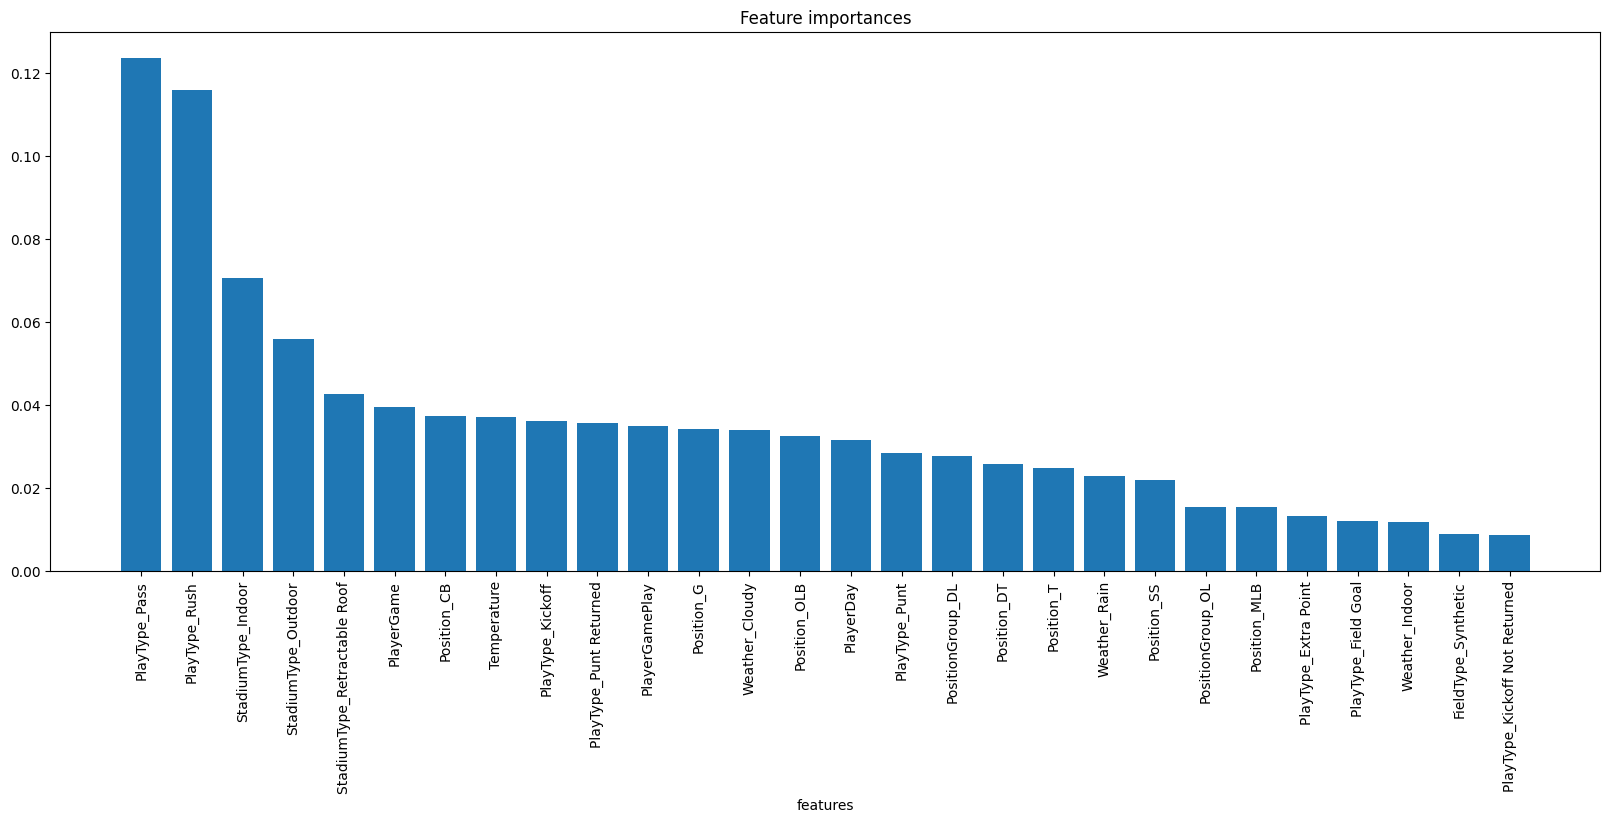

In [21]:
# plotando como gráfica de barras
plt.figure(figsize=(20,7))
plt.bar(range(len(feature_importances)), feature_importances.importance.values)
plt.xticks(range(len(feature_importances)), feature_importances.feature.values, rotation=90)

plt.title('Feature importances')
plt.xlabel('features')
plt.show()